In [1]:
import os
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:

# ------------------ FEDformer (Simplified) ------------------
class FourierBlock(nn.Module):
    """Lightweight frequency-domain attention block."""
    def __init__(self, top_k=10):
        super().__init__()
        self.top_k = top_k

    def forward(self, x):
        # x: (batch, seq_len, features)
        x_ft = torch.fft.rfft(x, dim=1)  # frequency domain
        abs_x = torch.abs(x_ft)

        # Select top-k frequencies
        topk = torch.topk(abs_x, self.top_k, dim=1).indices
        mask = torch.zeros_like(abs_x)
        mask.scatter_(1, topk, 1.0)
        x_ft_filtered = x_ft * mask

        x_ifft = torch.fft.irfft(x_ft_filtered, n=x.size(1), dim=1)
        return x_ifft

class FEDformer(nn.Module):
    def __init__(self, seq_len, n_features, forecast_horizon, d_model=128, top_k=10):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.d_model = d_model
        self.top_k = top_k
        
        self.enc_embedding = nn.Linear(n_features, d_model)
        self.fourier_block = FourierBlock(top_k)
        self.trend_block = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, forecast_horizon)
    
    def forward(self, x):
        x = self.enc_embedding(x)  # (B, seq_len, d_model)
        seasonal = self.fourier_block(x)
        trend = self.trend_block(x)
        combined = seasonal + trend
        pooled = combined.mean(dim=1)
        out = self.fc_out(pooled)
        return out

In [9]:
# ------------------ Dataset Preparation ------------------
def create_sequences(X_data, y_data, seq_len, forecast_horizon):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len - forecast_horizon):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len:i+seq_len+forecast_horizon].values)
    return np.array(X_seq), np.array(y_seq)

def desequence(predictions, seq_len, forecast_horizon):
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)
    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1
    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast


In [39]:
# Evaluation function for comparing two FedFormer models

def evaluate_two_fedformer_models(
    model_orig, model_aug, scaler, X_test, y_test, y_train_org, features, 
    seq_len, forecast_horizon, time_index=None, start_point=0, end_point=None
):
    # Subset test data before scaling
    X_test_sub = X_test.iloc[start_point:end_point].reset_index(drop=True)
    y_test_sub = y_test.iloc[start_point:end_point].reset_index(drop=True)

    # Scale only subset
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_sub), columns=features)
    X_seq, y_seq = create_sequences(X_test_scaled, y_test_sub, seq_len, forecast_horizon)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # Predictions: Original Model
    model_orig.eval()
    with torch.no_grad():
        preds_orig = model_orig(X_tensor).numpy()

    # Predictions: Augmented Model
    model_aug.eval()
    with torch.no_grad():
        preds_aug = model_aug(X_tensor).numpy()

    # De-sequence both forecasts and ground truth
    merged_pred_orig = desequence(preds_orig, seq_len, forecast_horizon)
    merged_pred_aug = desequence(preds_aug, seq_len, forecast_horizon)
    merged_true = desequence(y_seq, seq_len, forecast_horizon)

    # Inverse scaling target
    y_scaler = StandardScaler()
    y_scaler.fit(y_train_org.values.reshape(-1, 1))  # fit on full original training target

    merged_true_inv = y_scaler.inverse_transform(merged_true.reshape(-1, 1)).flatten()
    merged_pred_orig_inv = y_scaler.inverse_transform(merged_pred_orig.reshape(-1, 1)).flatten()
    merged_pred_aug_inv = y_scaler.inverse_transform(merged_pred_aug.reshape(-1, 1)).flatten()

    # Metrics: Original Model
    mse_orig = mean_squared_error(merged_true_inv, merged_pred_orig_inv)
    mae_orig = mean_absolute_error(merged_true_inv, merged_pred_orig_inv)
    rmse_orig = math.sqrt(mse_orig)

    # Metrics: Augmented Model
    mse_aug = mean_squared_error(merged_true_inv, merged_pred_aug_inv)
    mae_aug = mean_absolute_error(merged_true_inv, merged_pred_aug_inv)
    rmse_aug = math.sqrt(mse_aug)

    print(f"Original Model - MSE: {mse_orig:.4f}, MAE: {mae_orig:.4f}, RMSE: {rmse_orig:.4f}")
    print(f"Augmented Model - MSE: {mse_aug:.4f}, MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # Prepare time index for plotting
    if time_index is not None:
        plot_range = time_index[start_point + seq_len : end_point]
    else:
        plot_range = range(len(merged_true_inv))

    plt.figure(figsize=(16, 6))
    
    # Plot actual
    plt.plot(plot_range, merged_true_inv, label='Actual', color='black')
    
    # Plot forecasts
    plt.plot(plot_range, merged_pred_orig_inv, label='Shuffled Model Forecast', color='red', linestyle='--')
    plt.plot(plot_range, merged_pred_aug_inv, label='No Shuffled Model Forecast', color='green', linestyle=':')

    # Shade Actual vs Original Forecast (pink)
    plt.fill_between(plot_range, merged_true_inv, merged_pred_orig_inv,
                     where=(merged_true_inv >= merged_pred_orig_inv),
                     interpolate=True, color='pink', alpha=0.5, label='Error (Actual - Shuffle)')
    plt.fill_between(plot_range, merged_pred_orig_inv, merged_true_inv,
                     where=(merged_true_inv < merged_pred_orig_inv),
                     interpolate=True, color='pink', alpha=0.5)

    # Shade Original Forecast vs Augmented Forecast (light blue)
    plt.fill_between(plot_range, merged_pred_orig_inv, merged_pred_aug_inv,
                     where=(merged_pred_aug_inv >= merged_pred_orig_inv),
                     interpolate=True, color='lightblue', alpha=0.5, label='Difference (Shuffle - No Shuffle)')
    plt.fill_between(plot_range, merged_pred_aug_inv, merged_pred_orig_inv,
                     where=(merged_pred_aug_inv < merged_pred_orig_inv),
                     interpolate=True, color='lightblue', alpha=0.5)

    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("FEDformer Forecast Comparison: Shuffle vs No Shuffled Model")
    plt.legend()
    plt.grid(True)

    textstr = (
        f'Shuffled Model\nMAE: {mae_orig:.4f}\nRMSE: {rmse_orig:.4f}\n'
        f'No Shuffled Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


In [24]:
seq_len = 24
forecast_horizon = 12

X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])
y_test = org_test_processed[target]

In [25]:
import joblib

In [26]:
model_FEDformer_no_shuffle  = model = FEDformer(seq_len, len(features), forecast_horizon)
# Load model state_dict
model_path  = "../Models/weights/FEDformer_aug_modelV1_no_shuffle.pth"
model_FEDformer_no_shuffle.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_FEDformer_no_shuffle.eval()

print("Model loaded successfully.")


scaler_path = '../Models/weights/scaler_FEDformer_augV1.pkl'
scaler_FEDformer_aug = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.


In [27]:
model_FEDformer_org  = model = FEDformer(seq_len, len(features), forecast_horizon)
# Load model state_dict
model_path  = "../Models/weights/FEDformer_org_model.pth"
model_FEDformer_org.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_FEDformer_org.eval()

print("Model loaded successfully.")

Model loaded successfully.



Evaluating PatchTST on test data...
Original Model - MSE: 0.0029, MAE: 0.0432, RMSE: 0.0534
Augmented Model - MSE: 0.0029, MAE: 0.0422, RMSE: 0.0534


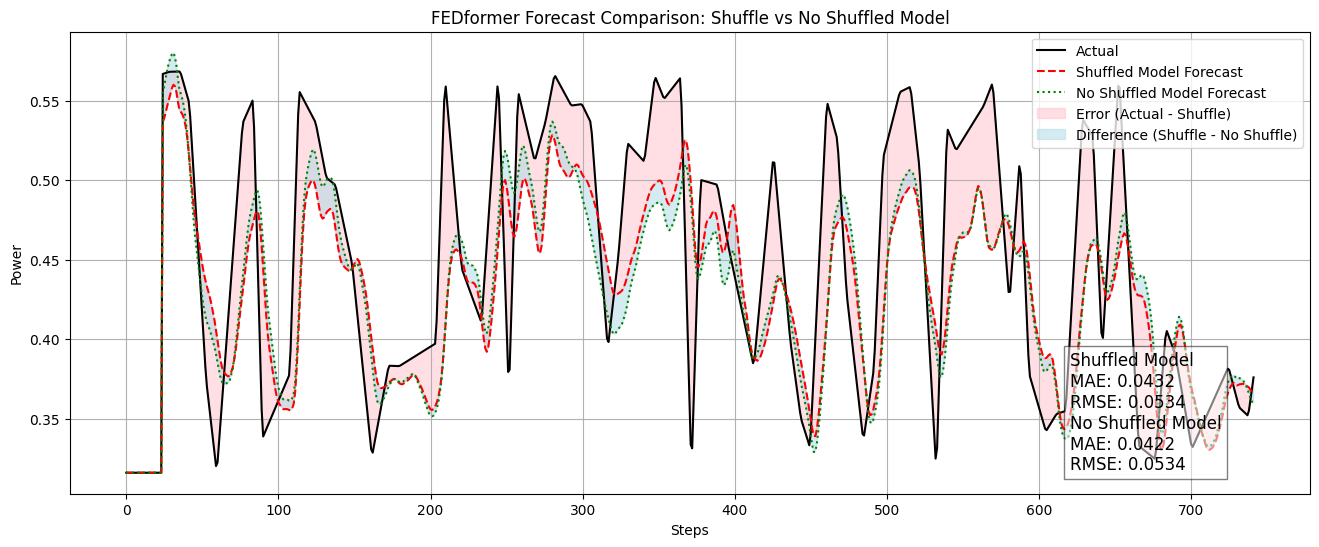

Original Model - MSE: 0.0012, MAE: 0.0268, RMSE: 0.0344
Augmented Model - MSE: 0.0014, MAE: 0.0289, RMSE: 0.0371


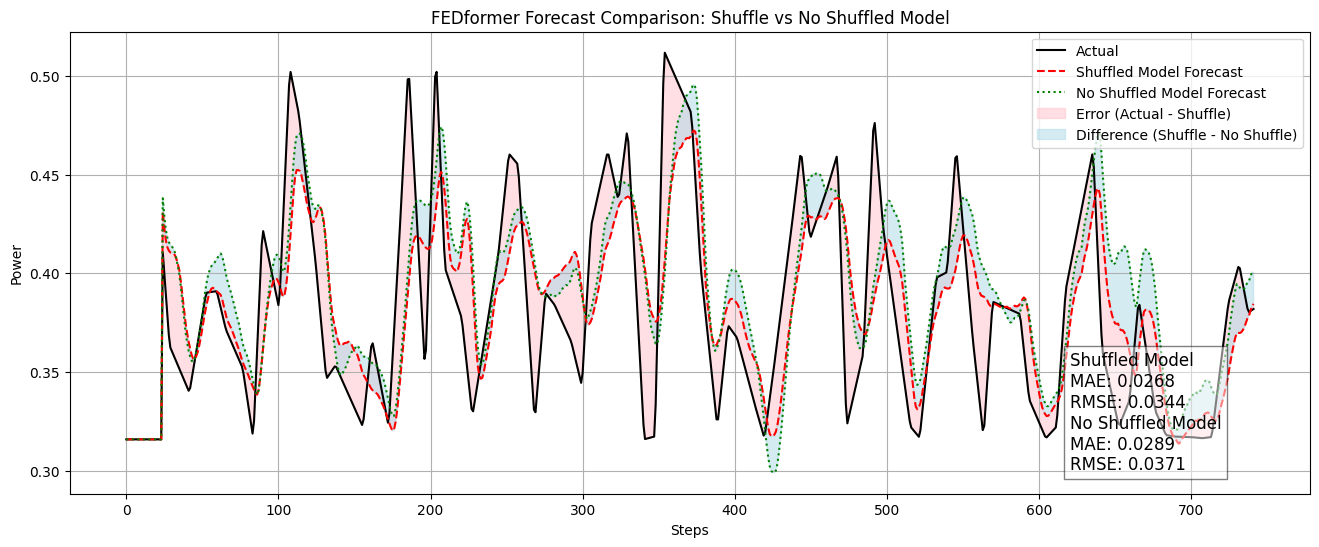

Original Model - MSE: 0.0038, MAE: 0.0514, RMSE: 0.0617
Augmented Model - MSE: 0.0037, MAE: 0.0503, RMSE: 0.0611


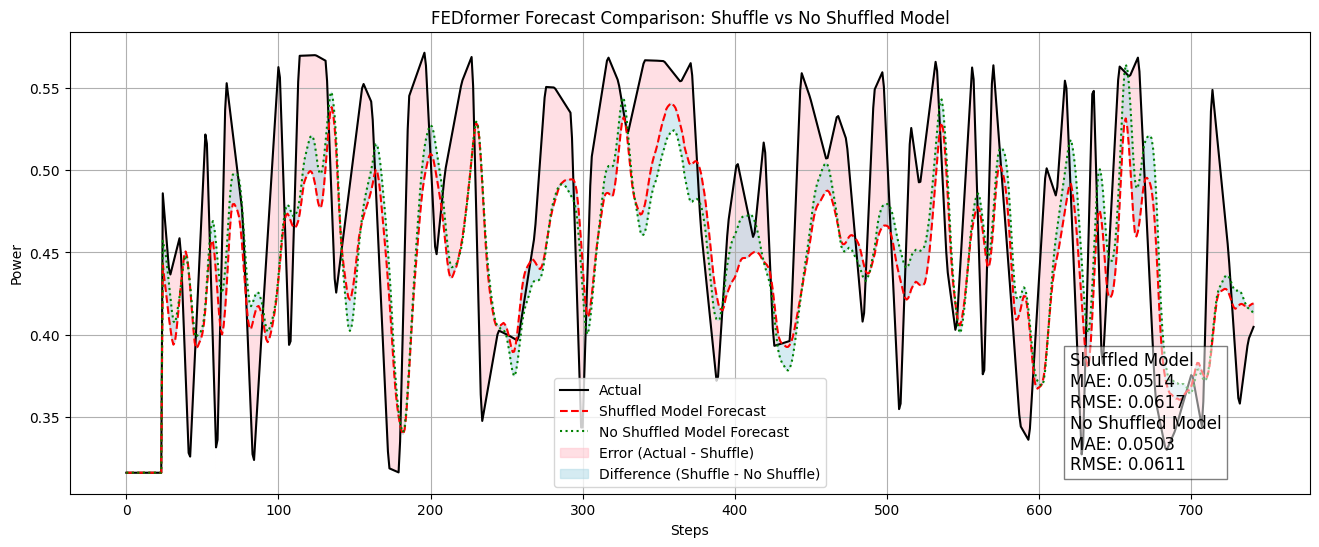

Original Model - MSE: 0.0020, MAE: 0.0349, RMSE: 0.0446
Augmented Model - MSE: 0.0021, MAE: 0.0370, RMSE: 0.0455


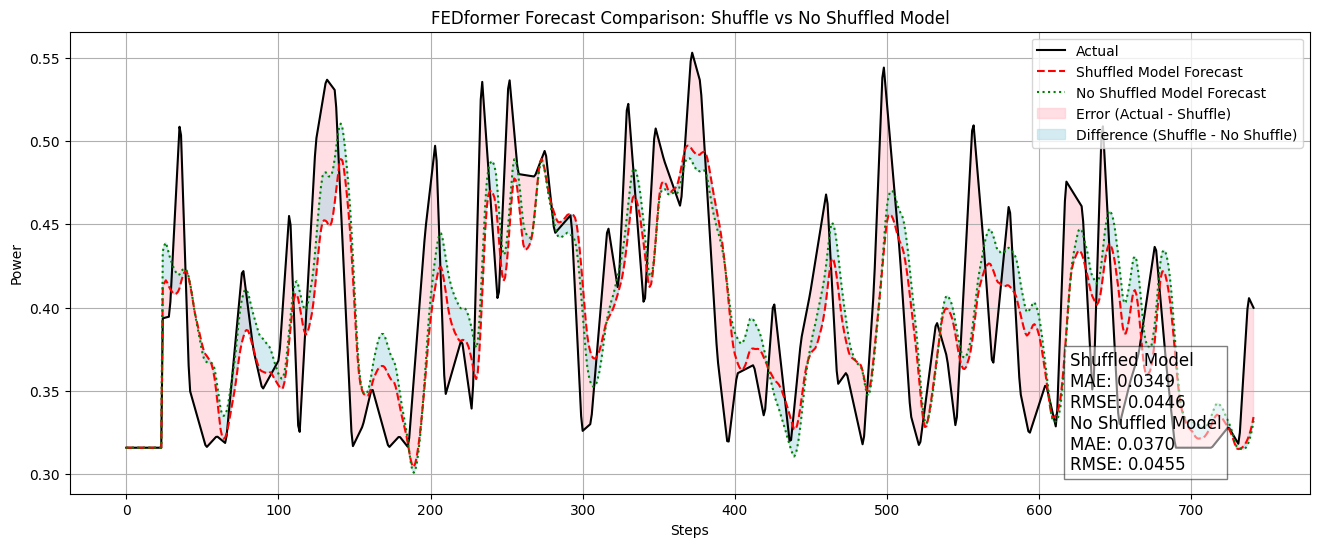

In [40]:
print("\nEvaluating PatchTST on test data...")
evaluate_two_fedformer_models(model_orig=model_FEDformer_org,model_aug=model_FEDformer_no_shuffle, scaler= scaler_FEDformer_aug, X_test=X_test, y_test= y_test,y_train_org=y_train_org,features= features, seq_len=seq_len, forecast_horizon=forecast_horizon, start_point=7991, end_point=8734)
evaluate_two_fedformer_models(model_orig=model_FEDformer_org,model_aug= model_FEDformer_no_shuffle, scaler= scaler_FEDformer_aug,X_test= X_test,y_test= y_test,y_train_org=y_train_org,features= features, seq_len=seq_len, forecast_horizon=forecast_horizon, start_point=16726, end_point=17469)
evaluate_two_fedformer_models(model_orig=model_FEDformer_org,model_aug= model_FEDformer_no_shuffle, scaler= scaler_FEDformer_aug, X_test=X_test,y_test= y_test,y_train_org=y_train_org,features= features,seq_len= seq_len, forecast_horizon=forecast_horizon,  start_point=25461, end_point=26204)
evaluate_two_fedformer_models(model_orig=model_FEDformer_org,model_aug= model_FEDformer_no_shuffle, scaler= scaler_FEDformer_aug, X_test=X_test,y_test= y_test,y_train_org=y_train_org,features= features,seq_len= seq_len, forecast_horizon= forecast_horizon,  start_point=34196, end_point=34939)


In [29]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math 

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100


def evaluate_monthly_timemoe_errors(
    model_orig, model_aug, 
    scaler_X, y_train_org,
    X_test, y_test, features,
    seq_len, forecast_horizon
):
    # Prepare index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    # Scale full test set
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=features)

    # Inverse scaler for target
    y_scaler = StandardScaler().fit(y_train_org.values.reshape(-1, 1))

    # Location slicing
    total_len = len(X_test)
    n_locations = 4
    loc_size = total_len // n_locations

    results = []

    for loc in range(n_locations):
        start_idx = loc * loc_size
        end_idx = (loc + 1) * loc_size

        # Data for this location
        X_loc = pd.DataFrame(X_test_scaled.iloc[start_idx:end_idx])
        y_loc = y_test.iloc[start_idx:end_idx]

        for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
            y_month = y_loc[df_month.index]

            if len(df_month) < seq_len + 1:
                continue

            # Create sequences
            X_seq, y_seq = create_sequences(df_month[features],y_month, seq_len,forecast_horizon)
            if len(X_seq) == 0:
                continue

            X_tensor = torch.tensor(X_seq, dtype=torch.float32)

            # Predict
            with torch.no_grad():
                model_orig.eval()
                model_aug.eval()
                preds_orig = model_orig(X_tensor).numpy()
                preds_aug = model_aug(X_tensor).numpy()

            # Desequence all
            merged_pred_org = desequence(preds_orig, seq_len, forecast_horizon)
            merged_pred_aug = desequence(preds_aug, seq_len, forecast_horizon)
            merged_true = desequence(y_seq, seq_len, forecast_horizon)

            # Inverse transform
            y_true = y_scaler.inverse_transform(merged_true.reshape(-1, 1)).flatten()
            preds_orig_inv = y_scaler.inverse_transform(merged_pred_org.reshape(-1, 1)).flatten()
            preds_aug_inv = y_scaler.inverse_transform(merged_pred_aug.reshape(-1, 1)).flatten()

            # Compute metrics
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_shuffle': mean_absolute_error(y_true, preds_orig_inv),
                'rmse_shuffle': math.sqrt(mean_squared_error(y_true, preds_orig_inv)),
                'mape_shuffle': mape(y_true, preds_orig_inv),
                'smape_shuffle': smape(y_true, preds_orig_inv),
                'r2_shuffle': r2_score(y_true, preds_orig_inv),
                'mae_no_shuffle': mean_absolute_error(y_true, preds_aug_inv),
                'rmse_no_shuffle': math.sqrt(mean_squared_error(y_true, preds_aug_inv)),
                'mape_no_shuffle': mape(y_true, preds_aug_inv),
                'smape_no_shuffle': smape(y_true, preds_aug_inv),
                'r2_no_shuffle': r2_score(y_true, preds_aug_inv)
            })

    results_df = pd.DataFrame(results)

    # Monthly average + std across 4 locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_shuffle': ['mean', 'std'],
        'rmse_shuffle': ['mean', 'std'],
        'mape_shuffle': ['mean', 'std'],
        'smape_shuffle': ['mean', 'std'],
        'r2_shuffle': ['mean', 'std'],
        'mae_no_shuffle': ['mean', 'std'],
        'rmse_no_shuffle': ['mean', 'std'],
        'mape_no_shuffle': ['mean', 'std'],
        'smape_no_shuffle': ['mean', 'std'],
        'r2_no_shuffle': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]

    return results_df, monthly_summary


In [30]:
results_df, monthly_summary = evaluate_monthly_timemoe_errors(
    model_orig=model_FEDformer_org,
    model_aug=model_FEDformer_no_shuffle,
    scaler_X=scaler_FEDformer_aug,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    features=features,
    seq_len=seq_len,
    forecast_horizon=forecast_horizon
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7188/4024246768.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7188/4024246768.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7188/4024246768.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7188/4024246768.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):


In [33]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_shuffle': f"{loc_data['mae_shuffle'].mean():.4f}  ± {loc_data['mae_shuffle'].std():.4f}",
        'rmse_shuffle': f"{loc_data['rmse_shuffle'].mean():.4f}  ± {loc_data['rmse_shuffle'].std():.4f}",
        'mape_shuffle': f"{loc_data['mape_shuffle'].mean():.4f}  ± {loc_data['mape_shuffle'].std():.4f}",
        'smape_shuffle': f"{loc_data['smape_shuffle'].mean():.4f}  ± {loc_data['smape_shuffle'].std():.4f}",
        'r2_shuffle': f"{loc_data['r2_shuffle'].mean():.4f}  ± {loc_data['r2_shuffle'].std():.4f}",
        'mae_no_shuffle': f"{loc_data['mae_no_shuffle'].mean():.4f}  ± {loc_data['mae_no_shuffle'].std():.4f}",
        'rmse_no_shuffle': f"{loc_data['rmse_no_shuffle'].mean():.4f}  ± {loc_data['rmse_no_shuffle'].std():.4f}",
        'mape_no_shuffle': f"{loc_data['mape_no_shuffle'].mean():.4f}  ± {loc_data['mape_no_shuffle'].std():.4f}",
        'smape_no_shuffle': f"{loc_data['smape_no_shuffle'].mean():.4f}  ± {loc_data['smape_no_shuffle'].std():.4f}",
        'r2_no_shuffle': f"{loc_data['r2_no_shuffle'].mean():.4f}  ± {loc_data['r2_no_shuffle'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_shuffle': f"{results_df['mae_shuffle'].mean():.4f}  ± {results_df['mae_shuffle'].std():.4f}",
    'rmse_shuffle': f"{results_df['rmse_shuffle'].mean():.4f}  ± {results_df['rmse_shuffle'].std():.4f}",
    'mape_shuffle': f"{results_df['mape_shuffle'].mean():.4f}  ± {results_df['mape_shuffle'].std():.4f}",
    'smape_shuffle': f"{results_df['smape_shuffle'].mean():.4f}  ± {results_df['smape_shuffle'].std():.4f}",
    'r2_shuffle': f"{results_df['r2_shuffle'].mean():.4f}  ± {results_df['r2_shuffle'].std():.4f}",
    'mae_no_shuffle': f"{results_df['mae_no_shuffle'].mean():.4f}  ± {results_df['mae_no_shuffle'].std():.4f}",
    'rmse_no_shuffle': f"{results_df['rmse_no_shuffle'].mean():.4f}  ± {results_df['rmse_no_shuffle'].std():.4f}",
    'mape_no_shuffle': f"{results_df['mape_no_shuffle'].mean():.4f}  ± {results_df['mape_no_shuffle'].std():.4f}",
    'smape_no_shuffle': f"{results_df['smape_no_shuffle'].mean():.4f}  ± {results_df['smape_no_shuffle'].std():.4f}",
    'r2_no_shuffle': f"{results_df['r2_no_shuffle'].mean():.4f}  ± {results_df['r2_no_shuffle'].std():.4f}",
})
final_results =  pd.DataFrame(final_results)

In [34]:
final_results

,Location,mae_shuffle,rmse_shuffle,mape_shuffle,smape_shuffle,r2_shuffle,mae_no_shuffle,rmse_no_shuffle,mape_no_shuffle,smape_no_shuffle,r2_no_shuffle
0,Location_1,0.0361 ± 0.0073,0.0466 ± 0.0078,8.2124 ± 1.2664,8.4324 ± 1.3317,0.5769 ± 0.0686,0.0366 ± 0.0076,0.0472 ± 0.0082,8.2520 ± 1.2878,8.5267 ± 1.3912,0.5667 ± 0.0687
1,Location_2,0.0242 ± 0.0051,0.0314 ± 0.0059,6.6057 ± 1.1439,6.5121 ± 1.1356,0.4547 ± 0.0675,0.0266 ± 0.0052,0.0338 ± 0.0059,7.3864 ± 1.2906,7.1468 ± 1.2114,0.3590 ± 0.1205
2,Location_3,0.0292 ± 0.0152,0.0362 ± 0.0180,7.3148 ± 2.8035,7.3061 ± 2.9187,0.1060 ± 1.0030,0.0309 ± 0.0140,0.0382 ± 0.0166,7.8763 ± 2.4919,7.7738 ± 2.5904,-0.1472 ± 1.4285
3,Location_4,0.0257 ± 0.0068,0.0342 ± 0.0080,6.5487 ± 1.4343,6.5877 ± 1.4480,0.5728 ± 0.0947,0.0255 ± 0.0066,0.0332 ± 0.0078,6.5742 ± 1.4570,6.5422 ± 1.4341,0.5901 ± 0.1173
4,All Location Combined,0.0288 ± 0.0103,0.0371 ± 0.0121,7.1704 ± 1.8615,7.2096 ± 1.9515,0.4276 ± 0.5267,0.0299 ± 0.0098,0.0381 ± 0.0116,7.5222 ± 1.7692,7.4974 ± 1.8446,0.3421 ± 0.7583


In [35]:
monthly_summary

,month,mae_shuffle_mean,mae_shuffle_std,rmse_shuffle_mean,rmse_shuffle_std,mape_shuffle_mean,mape_shuffle_std,smape_shuffle_mean,smape_shuffle_std,r2_shuffle_mean,...,mae_no_shuffle_mean,mae_no_shuffle_std,rmse_no_shuffle_mean,rmse_no_shuffle_std,mape_no_shuffle_mean,mape_no_shuffle_std,smape_no_shuffle_mean,smape_no_shuffle_std,r2_no_shuffle_mean,r2_no_shuffle_std
0,2021-01,0.026797,0.007768,0.034941,0.008622,6.858863,1.399288,6.851455,1.515086,0.545651,...,0.028163,0.009351,0.036672,0.010430,7.234828,1.741743,7.212234,1.907878,0.482276,0.242802
1,2021-02,0.026343,0.009699,0.034686,0.011785,6.609972,1.530353,6.642606,1.695240,0.529305,...,0.028502,0.011349,0.037462,0.013474,7.158555,1.772688,7.146647,2.018611,0.441124,0.210984
2,2021-03,0.034196,0.011254,0.042400,0.013924,8.461709,1.587330,8.448945,1.809855,0.451678,...,0.035131,0.009321,0.043254,0.011579,8.823876,1.042813,8.734301,1.312806,0.392096,0.220708
3,2021-04,0.030498,0.006773,0.039301,0.008708,7.653337,0.870298,7.722202,1.061116,0.437890,...,0.031375,0.005833,0.040756,0.007557,7.979426,0.783238,7.955753,0.933097,0.379750,0.158886
4,2021-05,0.024741,0.006242,0.032041,0.008572,6.484593,1.085006,6.484414,1.195330,0.475044,...,0.025860,0.006086,0.033009,0.008143,6.824449,1.096612,6.788372,1.183896,0.421629,0.277258
5,2021-06,0.022319,0.008103,0.030272,0.011194,5.840320,1.475176,5.874132,1.609247,0.456687,...,0.024932,0.005290,0.032303,0.008081,6.729438,1.043658,6.645074,1.041443,0.246729,0.561295
6,2021-07,0.018692,0.007712,0.024785,0.011113,5.056238,1.647594,5.075539,1.719142,-0.391095,...,0.019336,0.007181,0.025056,0.010396,5.275270,1.476027,5.269463,1.565527,-0.765327,2.544205
7,2021-08,0.019434,0.005279,0.026268,0.007194,5.293152,1.323019,5.279906,1.307272,0.527592,...,0.021225,0.004935,0.028110,0.006229,5.870338,1.296137,5.769112,1.225705,0.438821,0.156061
8,2021-09,0.029857,0.005323,0.038519,0.006760,7.526699,1.046694,7.573411,1.065770,0.518850,...,0.030470,0.005250,0.038841,0.006978,7.731188,1.125218,7.708971,1.099424,0.505996,0.146229
9,2021-10,0.033149,0.010703,0.043582,0.012841,7.913232,1.874465,8.030008,2.013729,0.604137,...,0.031899,0.009772,0.041817,0.012292,7.614312,1.660591,7.739324,1.819244,0.634904,0.051499


In [36]:
FOLDER_NAME = './Results/FEDformer'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)